In [18]:
%matplotlib inline

# Imports
import os

# Packages
import numpy
import numpy.random
import matplotlib.pyplot as plt

import pandas
import sklearn
import sklearn.ensemble
import sklearn.metrics
import sklearn.model_selection
import sklearn.experimental

## Parameter setup

The cell below sets key parameters like:
* relative/absolute path to feature and target data
* vector type, e.g., spacy model; see scripts/ folder --help
* target name, e.g., issue or issueArea
* court - only "scotus" currently supported
* data_type - only "opinions" currently supported
* year - SCDB release year
* release - SCDB release version

In [95]:
# Set parameters
path = "../data/"
vector_type = "spacy-en-large"
target_name = "issueArea"
court = "scotus"
data_type = "opinions"
year = 2020
release = 1

# Get file names
feature_file_path = os.path.join(path,
                                 f"features-{vector_type}-{court}-{data_type}-{year}-{release}.csv.gz")
if not os.path.exists(feature_file_path):
    raise RuntimeError(f"feature file {feature_file_path} does not exist for given parameters")

target_file_path = os.path.join(path,
                                 f"targets-{court}-{data_type}-{year}-{release}.csv.gz")
if not os.path.exists(target_file_path):
    raise RuntimeError(f"target file {target_file_path} does not exist for given parameters")

In [3]:
# read dataframes
feature_df = pandas.read_csv(feature_file_path, low_memory=False, index_col=0)
target_df = pandas.read_csv(target_file_path, index_col=0).iloc[:, 0]

print(f"feature shape: {feature_df.shape}")
print(f"target shape: {target_df.shape}")

feature shape: (7551, 300)
target shape: (7551,)


## Random State Setup

We try to control experiment RNG state via numpy RandomState objects, which can be passed into sklearn in recent releases.
This allows us to fix or purposefully randomize random contribution to results, e.g., train-test splits, subsampling, and tree splits.

In [4]:
# Set seed/RandomState here
seed = 0
random_state = numpy.random.RandomState(seed=seed)

##  Model Pipeline Setup

The cell belows defines a very simple cross-validated random forest pipeline with hyperparameter optimization.

N.B. that `n_jobs` can be set to -1 or another value >1 to increase performance.

In [60]:
# Hyperparameter search space
param_search_space = {"n_estimators": [2**6, 2**8, 2**10],
                     "max_depth": [None],
                     "min_samples_leaf": [2**0, 2**1, 2**2],
                      "max_features": ["auto"],
                     }

# CV and model pipeline setup
rf_model = sklearn.ensemble.RandomForestClassifier(random_state=random_state)
cv = sklearn.model_selection.RepeatedStratifiedKFold(n_splits=5, random_state=random_state)
model_selector = sklearn.model_selection.GridSearchCV(estimator=rf_model, param_grid=param_search_space, 
                                     cv=cv, scoring="f1_weighted", verbose=2, n_jobs=1)
model_selector.fit(feature_df, target_df)

Fitting 50 folds for each of 5 candidates, totalling 250 fits


GridSearchCV(cv=RepeatedStratifiedKFold(n_repeats=10, n_splits=5,
            random_state=RandomState(MT19937) at 0x235C2BD9340),
             estimator=RandomForestClassifier(random_state=RandomState(MT19937) at 0x235C2BD9340),
             n_jobs=4,
             param_grid={'max_depth': [None], 'max_features': ['auto'],
                         'min_samples_leaf': [2],
                         'n_estimators': [4, 16, 64, 256, 1024]},
             scoring='f1_weighted', verbose=2)

## Insample Model Assessment

This is in-sample performance assessment for the *refit*, hyperparameter-optimized model from above.

These results are not "real" - but poor performance or class-specific issues here need to be reviewed.

In [73]:
# Insample prediction assessment
insample_prediction_list = model_selector.best_estimator_.predict(feature_df)

print("Best model parameters:")
for k in model_selector.best_params_:
    print(f"\t{k}={model_selector.best_params_[k]}")

print("\nModel assessment:")
print(sklearn.metrics.classification_report(target_df, insample_prediction_list))

cv_result_df = pandas.DataFrame(model_selector.cv_results_)

Best model parameters:
	max_depth=None
	max_features=auto
	min_samples_leaf=2
	n_estimators=1024

Model assessment:
              precision    recall  f1-score   support

           1       0.99      1.00      1.00      1657
           2       1.00      1.00      1.00      1213
           3       1.00      1.00      1.00       608
           4       1.00      0.98      0.99       311
           5       1.00      1.00      1.00        91
           6       1.00      1.00      1.00        81
           7       1.00      1.00      1.00       327
           8       1.00      1.00      1.00      1481
           9       1.00      1.00      1.00      1044
          10       1.00      0.99      1.00       348
          11       1.00      1.00      1.00        82
          12       1.00      1.00      1.00       292
          13       1.00      1.00      1.00        16

    accuracy                           1.00      7551
   macro avg       1.00      1.00      1.00      7551
weighted avg      

## Train-Test Split Assessment

This is "out-of-sample" assessment with a 75/25 train/test split.  The hyperparameters are obviously selected from the process above, and the transformer models include "future" information relative to the cases, but this is how most researchers assess performance for comparison.

In [96]:
# get splits
feature_train_df, feature_test_df, target_train_df, target_test_df = \
    sklearn.model_selection.train_test_split(feature_df, target_df, train_size=0.75)

# setup and fit model
rf_split_model = sklearn.ensemble.RandomForestClassifier(**model_selector.best_params_, random_state=random_state)
rf_split_model.fit(feature_train_df, target_train_df)

# print assessment
print("\nModel assessment:")
rf_prediction_list = rf_split_model.predict(feature_test_df)
print(sklearn.metrics.classification_report(target_test_df, rf_prediction_list))



Model assessment:
              precision    recall  f1-score   support

           1       0.73      0.88      0.80       391
           2       0.67      0.70      0.68       315
           3       0.79      0.62      0.70       150
           4       1.00      0.01      0.03        72
           5       1.00      0.10      0.18        20
           6       1.00      0.05      0.09        22
           7       0.77      0.60      0.68        85
           8       0.60      0.80      0.69       370
           9       0.55      0.63      0.59       284
          10       0.87      0.25      0.38        81
          11       1.00      0.26      0.41        23
          12       0.88      0.68      0.77        72
          13       0.00      0.00      0.00         3

    accuracy                           0.67      1888
   macro avg       0.76      0.43      0.46      1888
weighted avg       0.70      0.67      0.64      1888



C:\ProgramData\Anaconda3\envs\scdb-issue-model\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\ProgramData\Anaconda3\envs\scdb-issue-model\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\ProgramData\Anaconda3\envs\scdb-issue-model\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, le

## Model parameter and performance explorations

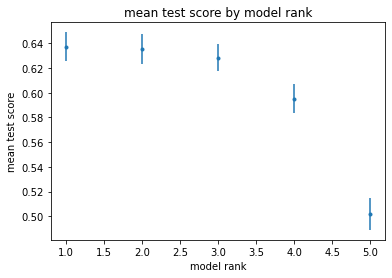

In [100]:
# Plot F1 score by model rank with error bars from CV
f = plt.figure()
f.gca().errorbar(x=cv_result_df["rank_test_score"], y=cv_result_df["mean_test_score"],
                yerr=cv_result_df["std_test_score"], fmt='.')

_ = f.gca().set_xlabel("model rank")
_ = f.gca().set_ylabel("mean test score")
_ = f.gca().set_title("mean test score by model rank")

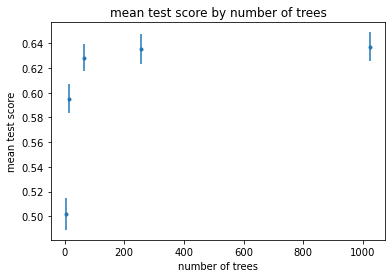

In [101]:
# Plot F1 score by number of trees with error bars from CV
f = plt.figure()
f.gca().errorbar(x=[p['n_estimators'] for p in cv_result_df["params"]],
                y=cv_result_df["mean_test_score"],
                 yerr=cv_result_df["std_test_score"], fmt='.')

_ = f.gca().set_xlabel("number of trees")
_ = f.gca().set_ylabel("mean test score")
_ = f.gca().set_title("mean test score by number of trees")

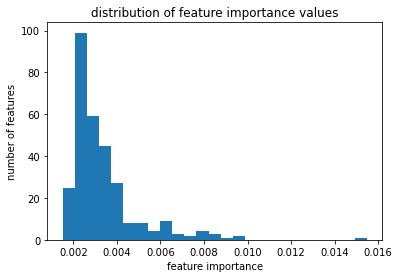

In [102]:
# plot distribution of feature importances
f = plt.figure()
_ = f.gca().hist(model_selector.best_estimator_.feature_importances_, bins=25)
_ = f.gca().set_xlabel("feature importance")
_ = f.gca().set_ylabel("number of features")
_ = f.gca().set_title("distribution of feature importance values")